In [2]:
import numpy as np
from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import IBMQ
provider = IBMQ.load_account()
from collections import OrderedDict
from operator import itemgetter
IBMQ.providers()


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>,
 <AccountProvider for IBMQ(hub='q-summer-school', group='main', project='project-2')>]

In [3]:
# provider = IBMQ.load_account()
# provider.backends()

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='fall-22-29')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-2

In [5]:
def misere_step(ones,piles):
    # even number of piles of 1 eg (1,1,3,0) or (0,0,3,0)
    if ones%2 == 0:
        objects_to_remove = []
        removable_amount = 1
        for i in range(len(piles)):
            if piles[i] > 1:
                objects_to_remove.append(piles[i]-1)
            else:
                objects_to_remove.append(0)
    # odd number of piles of 1 eg (1,1,3,1)
    else:
        objects_to_remove = []
        removable_amount = 1
        for i in range(len(piles)):
            if piles[i] > 1:
                objects_to_remove.append(piles[i])
            else:
                objects_to_remove.append(0)
    return objects_to_remove, removable_amount

def get_piles_to_remove(piles):
    nim_sum = 0
    for p in piles:
        nim_sum = nim_sum ^ p
    objects_to_remove = []
    removable_amount = 0
    for p in piles:
        new_p = p^nim_sum
        if new_p < p:
            objects_to_remove.append(p-new_p)
            removable_amount = removable_amount + 1
        else:
            objects_to_remove.append(0)
    return objects_to_remove, removable_amount


In [6]:
def custom_qft(data_qubits):
    qr_data = QuantumRegister(data_qubits)
    qc = QuantumCircuit(qr_data)
    i = data_qubits
    while i>=1:
        n = i - 1
        qc.h(qr_data[n]) 
        for qubit in range(n):
            qc.cp(np.pi/2**(n-qubit), qr_data[qubit], qr_data[n])
        i = i-1
    return qc

def subroutine_add_const(data_qubits: int, const: int, to_gate=True):
    qc = QuantumCircuit(data_qubits)
    for i in range(data_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)
    return qc.to_gate(label=" ["+str(const)+"] ") if to_gate else qc

In [7]:
def diffusion_operation(qc, address, flag, removable_pile):
    def nim_oracle(qc,address,flag,removable_pile):

        # 0001 -> 001
        if removable_pile[0] != 0:
            print("Removable Pile 0")
            qc.x(address[1])
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
            qc.x(address[1])
        
        # 0010 -> 010
        if removable_pile[1] != 0:
            print("Removable Pile 1")
            qc.x(address[0])
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
            qc.x(address[0])
    
        # 0100 -> 011
        if removable_pile[2] != 0:
            print("Removable Pile 2")
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
        
        # 1000 -> 100
        if removable_pile[3] != 0:
            print("Removable Pile 3")
            qc.x(address[0])
            qc.x(address[1])
            qc.mct(address[:],flag)
            qc.x(address[1])
            qc.x(address[0])


    qc.x(flag)
    qc.h(flag)

    qc.h(address[:])
    nim_oracle(qc,address,flag,removable_pile)
    qc.h(address[:])
    qc.x(address[:])
    qc.h(address[2])
    qc.mct(address[0:2], address[2])
    qc.h(address[2])
    qc.x(address[:])
    qc.h(address[:])
    

In [21]:
def qc_process(qc,objects_to_remove,address,removable_pile,removable_count):
    
    if removable_count == 0:
        for i in range(len(removable_pile)):
            if piles[i] != 0 and piles[i] != min(piles):
                removable_pile[i] += 1
                
    if removable_count == 4:
        final_board = []
        for i in range(len(removable_pile)):
            final_board.append(piles[i]-removable_pile[i])
        removable_pile[final_board.index(min(final_board))] = 0
        removable_count = removable_count - 1
    
    qft_gate = custom_qft(3).to_gate()
    inverse_qft_gate = custom_qft(3).inverse().to_gate()

    if removable_count == 1:
        qc.swap(objects_to_remove[0],objects_to_remove[2])
        qc.append(qft_gate,objects_to_remove[:])
        # 0001 -> 001
        if removable_pile[0] != 0:
            add_gate = subroutine_add_const(3,removable_pile[0])
            qc.x(address[0])
        # 0010 -> 010
        elif removable_pile[1] != 0:
            add_gate = subroutine_add_const(3,removable_pile[1])
            qc.x(address[1])
        # 0100 -> 011
        elif removable_pile[2] != 0:
            add_gate = subroutine_add_const(3,removable_pile[2])
            qc.x(address[0])
            qc.x(address[1])
        # 1000 -> 100
        elif removable_pile[3] != 0:
            add_gate = subroutine_add_const(3,removable_pile[3])
            qc.x(address[2])

        qc.append(add_gate,objects_to_remove[:])
        qc.append(inverse_qft_gate,objects_to_remove[:])
        qc.swap(objects_to_remove[0],objects_to_remove[2])

    else:
        diffusion_operation(qc,address, flag, removable_pile)
        qc.swap(objects_to_remove[0],objects_to_remove[2])
        qc.append(qft_gate,objects_to_remove[:])
        for i,remove_amount in enumerate(removable_pile):
            if remove_amount != 0:

                bin_i = list(bin(i+1)[2:])
                while len(bin_i) != 3:
                    bin_i.insert(0,'0')
                bin_i = bin_i[::-1]
                for j in range(len(bin_i)):
                    if bin_i[j] == '0':
                        qc.x(address[j])

                controlled_add_gate = subroutine_add_const(3,remove_amount).control(3)    
                qc.append(controlled_add_gate,address[:]+objects_to_remove[:])

                for j in range(len(bin_i)):
                    if bin_i[j] == '0':
                        qc.x(address[j])

        qc.append(inverse_qft_gate,objects_to_remove[:])
        qc.swap(objects_to_remove[0],objects_to_remove[2])

In [40]:
## check misere_step

# piles = [1,3,4,5]
piles = [1,2,6,7]
# piles = [6,6,7,6]
# piles = [1,3,4,7]
# piles = [0,0,7,7]
# piles = [1,3,2,0]
# piles = [1,2,4,7]
# piles = [1,0,0,4]

ones = piles.count(1)
zeros = piles.count(0)
non_zeros = 4 - (ones+zeros)

# all zeros except one eg (0,0,0,7) OR some zeros some ones some non_zeros
# leave odd piles of 1s
if non_zeros == 1: 
    removable_pile, removable_count = misere_step(ones, piles) 
else:
    removable_pile, removable_count = get_piles_to_remove(piles)
print(removable_pile, removable_count)

objects_to_remove = QuantumRegister(3,'piles')
flag = QuantumRegister(1,'flag')
output_piles = ClassicalRegister(3,'final_piles')
address = QuantumRegister(3,'address')
pick_pile = ClassicalRegister(3,'choose_pile')
qc = QuantumCircuit(objects_to_remove,address,flag,output_piles,pick_pile)
qc_process(qc,objects_to_remove,address,removable_pile,removable_count)




[0, 2, 2, 2] 3
Removable Pile 1
Removable Pile 2
Removable Pile 3


In [35]:
qc.measure(address[:],pick_pile[:])
qc.measure(objects_to_remove[:],output_piles[:])


In [36]:
backend = BasicAer.get_backend('qasm_simulator')
# backend = provider.backends.ibmq_qasm_simulator
# backend = provider.get_backend('ibm_nairobi')
job = execute(qc,backend,shots=1024)
result = job.result()
counts = result.get_counts()
qc_move = (counts.most_frequent())
counts

{'001 100': 293,
 '100 100': 281,
 '011 000': 30,
 '010 100': 285,
 '101 000': 31,
 '111 000': 40,
 '110 000': 37,
 '000 000': 27}

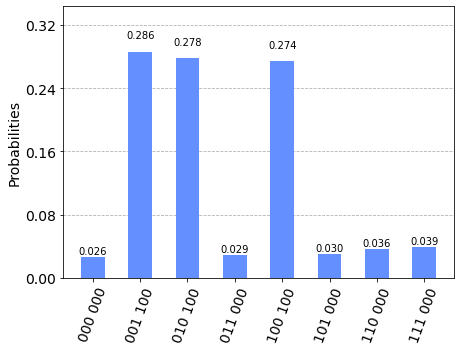

In [37]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [26]:
backend = provider.backends.ibmq_qasm_simulator
job = execute(qc,backend,shots=1024)
result = job.result()
counts = result.get_counts()
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by counts
print(counts)
counts

OrderedDict([('010 110', 1024)])


OrderedDict([('010 110', 1024)])

In [27]:
backend.jobs

<bound method IBMQBackend.jobs of <IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>>

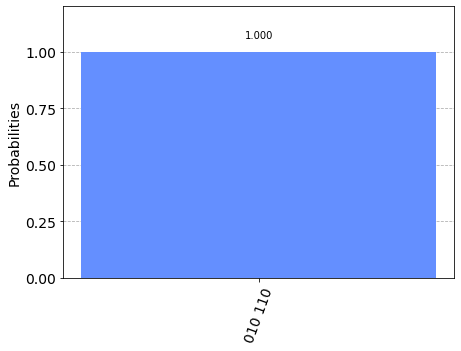

In [28]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [29]:
from qiskit.providers.aer import QasmSimulator
sim_noisy_nairobi = QasmSimulator.from_backend(provider.get_backend('ibm_nairobi'))
job = execute(qc,sim_noisy_nairobi,shots=1024)
result = job.result()
counts = result.get_counts()
# qc_move = (counts.most_frequent())
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by counts
print(counts)
counts

OrderedDict([('010 110', 725), ('010 100', 68), ('010 111', 53), ('000 110', 49), ('010 101', 40), ('010 010', 34), ('110 110', 12), ('011 110', 9), ('010 000', 8), ('000 100', 6), ('010 001', 5), ('010 011', 3), ('000 010', 3), ('000 111', 2), ('011 010', 2), ('000 101', 2), ('011 100', 1), ('001 110', 1), ('011 111', 1)])


OrderedDict([('010 110', 725),
             ('010 100', 68),
             ('010 111', 53),
             ('000 110', 49),
             ('010 101', 40),
             ('010 010', 34),
             ('110 110', 12),
             ('011 110', 9),
             ('010 000', 8),
             ('000 100', 6),
             ('010 001', 5),
             ('010 011', 3),
             ('000 010', 3),
             ('000 111', 2),
             ('011 010', 2),
             ('000 101', 2),
             ('011 100', 1),
             ('001 110', 1),
             ('011 111', 1)])

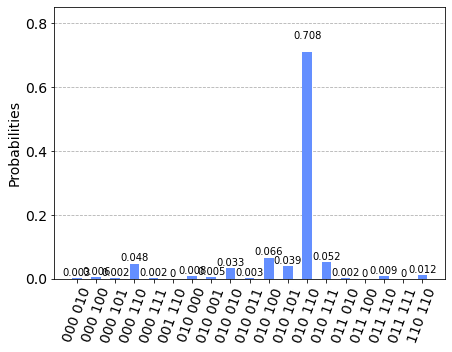

In [30]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [31]:
from qiskit.providers.aer import QasmSimulator
sim_noisy_oslo = QasmSimulator.from_backend(provider.get_backend('ibm_oslo'))
job = execute(qc,sim_noisy_oslo,shots=1024)
result = job.result()
counts = result.get_counts()
# qc_move = (counts.most_frequent())
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by count
print(counts)
counts

OrderedDict([('010 110', 824), ('010 010', 46), ('010 100', 42), ('010 111', 39), ('010 101', 17), ('011 110', 16), ('010 000', 11), ('010 001', 11), ('110 110', 6), ('010 011', 5), ('000 110', 4), ('011 100', 2), ('011 111', 1)])


OrderedDict([('010 110', 824),
             ('010 010', 46),
             ('010 100', 42),
             ('010 111', 39),
             ('010 101', 17),
             ('011 110', 16),
             ('010 000', 11),
             ('010 001', 11),
             ('110 110', 6),
             ('010 011', 5),
             ('000 110', 4),
             ('011 100', 2),
             ('011 111', 1)])

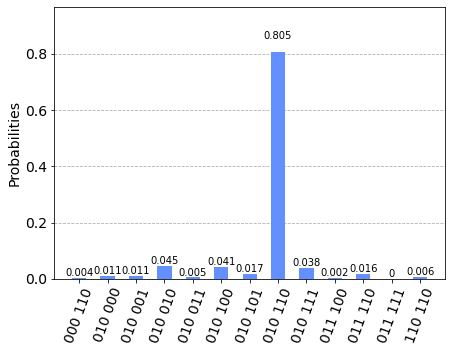

In [32]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

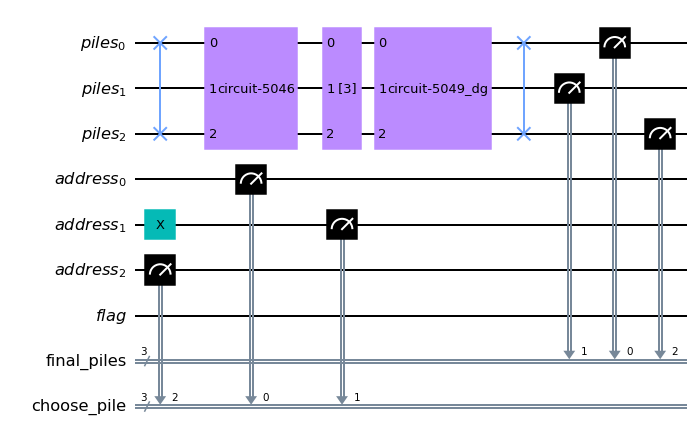

In [33]:
qc.draw(output='mpl')

In [151]:
board_choice = qc_move.split(' ')[0]
# board_choice = board_choice[::-1]

print(board_choice)
board_choice = int(board_choice,2)

print("Pick from:",board_choice)
board_state = qc_move.split(' ')[1]


board_state = board_state[::-1]
amount = int(board_state,2)
print("Amount:", amount)

010
Pick from: 2
Amount: 3
